In [1]:
import pyemma
import mdtraj as md
import numpy as np
import MDAnalysis as mda

In [8]:
# Load your topology and trajectories (adjust paths as needed)
topology = 'trajs/6.6_2.gro'
init = ['trajs/rep1_whole.xtc']
# trajectories = ['trajs/rep3_skip10_whole.xtc']  # Add all your trajectory files here
trajectories = ['trajs/rep1_whole.xtc','trajs/rep3_skip10_whole.xtc','trajs/5_whole.xtc','trajs/9_whole.xtc','trajs/1_whole.xtc','trajs/3_whole.xtc'] 


In [9]:
mda_list = []
for item in trajectories:
    u = mda.Universe(topology, item)
    mda_list.append(u)
    print(item)

trajs/rep1_whole.xtc
trajs/rep3_skip10_whole.xtc
trajs/5_whole.xtc
trajs/9_whole.xtc
trajs/1_whole.xtc
trajs/3_whole.xtc


In [10]:
reference = md.load(topology)

# Load the trajectories
# trajectories = md.load(trajectories, top=topology)
init = md.load(init, top=topology)


In [11]:
protein_ca_indices = init.topology.select('name CA and protein')
lipid_p_indices = init.topology.select('name P and resname POPC')

In [12]:
rmsd_values = []
penetration_depths = []

In [13]:
def calc_rmsd(traj):
    # Select the atoms for RMSD calculation, e.g., backbone atoms
    atom_indices = reference.topology.select('backbone')

    # Calculate RMSD with respect to the first frame of the reference
    rmsd_values = md.rmsd(target=traj, reference=init[1000], atom_indices=atom_indices)
    
    return(rmsd_values)



In [14]:
def compute_penetration_depth(traj, protein_ca_indices, lipid_p_indices):

    lipid_p_positions = traj.xyz[:, lipid_p_indices]

    lipid_p_indices_top = lipid_p_indices[lipid_p_positions[..., 2].mean(axis=0) >= traj.unitcell_lengths[:, 2].mean() / 2]
    lipid_p_indices_bottom = lipid_p_indices[lipid_p_positions[..., 2].mean(axis=0) < traj.unitcell_lengths[:, 2].mean() / 2]

    lipid_p_com_top = md.compute_center_of_mass(traj.atom_slice(lipid_p_indices_top))
    lipid_p_com_bottom = md.compute_center_of_mass(traj.atom_slice(lipid_p_indices_bottom))

    protein_ca_positions = traj.xyz[:, protein_ca_indices]

    penetration_depth = np.empty((traj.n_frames, len(protein_ca_indices)))

    for frame in range(traj.n_frames):
        dist_top = np.linalg.norm(protein_ca_positions[frame] - lipid_p_com_top[frame], axis=-1)
        dist_bottom = np.linalg.norm(protein_ca_positions[frame] - lipid_p_com_bottom[frame], axis=-1)
        binding_to_top = dist_top < dist_bottom

        penetration_depth[frame] = np.where(binding_to_top, protein_ca_positions[frame, :, 2] - lipid_p_com_top[frame, 2],
                                            protein_ca_positions[frame, :, 2] - lipid_p_com_bottom[frame, 2])

        box_half_z = traj.unitcell_lengths[frame, 2] / 2

        for i, depth in enumerate(penetration_depth[frame]):
            if depth > 0 and protein_ca_positions[frame, i, 2] < lipid_p_com_bottom[frame, 2] and not binding_to_top[i]:
                penetration_depth[frame, i] = -depth
            elif depth < 0 and protein_ca_positions[frame, i, 2] < box_half_z:
                penetration_depth[frame, i] = np.abs(depth)

            if depth > 0 and protein_ca_positions[frame, i, 2] < box_half_z and not binding_to_top[i]:
                penetration_depth[frame, i] = -depth

    return penetration_depth

In [15]:
for traj_file in trajectories:
    
    traj = md.load(traj_file, top = topology)
    value = calc_rmsd(traj)
    rmsd_values.extend(value)
    
    av_pen_depth = compute_penetration_depth(traj, protein_ca_indices, lipid_p_indices)
    penetration_depths.extend(av_pen_depth)
    
    

In [16]:
# Convert lists to numpy arrays for plotting
all_rmsd_values = np.array(rmsd_values)
all_average_penetration_depths = np.array(penetration_depths)

In [17]:
average_pen = np.mean(all_average_penetration_depths, axis=1)

In [18]:
np.shape(all_rmsd_values)

(6406,)

In [19]:
np.shape(average_pen)

(6406,)

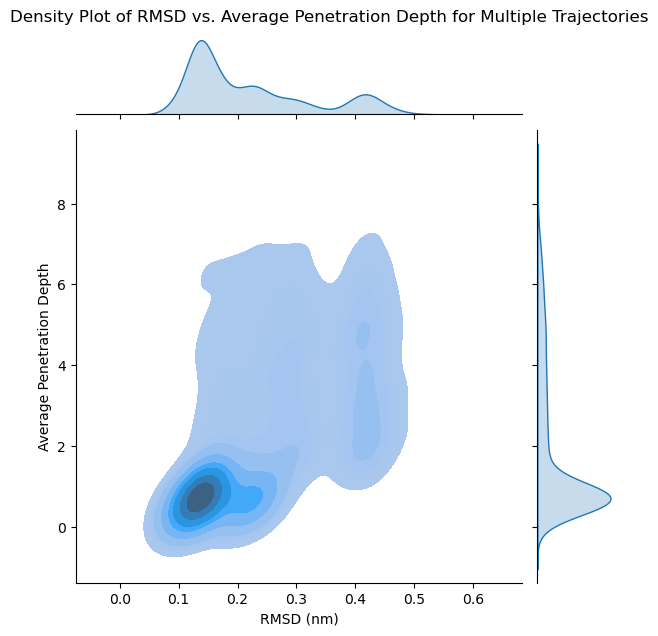

In [20]:
# Plotting the density plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.jointplot(x=all_rmsd_values, y=average_pen, kind="kde", fill=True,bw_adjust=1)

plt.xlabel('RMSD (nm)')
plt.ylabel('Average Penetration Depth')
plt.suptitle('Density Plot of RMSD vs. Average Penetration Depth for Multiple Trajectories', y=1.02)

plt.show()

/tmp/ipykernel_6904/1529696523.py:10: RuntimeWarning: divide by zero encountered in log
  free_energy = -np.log(h)


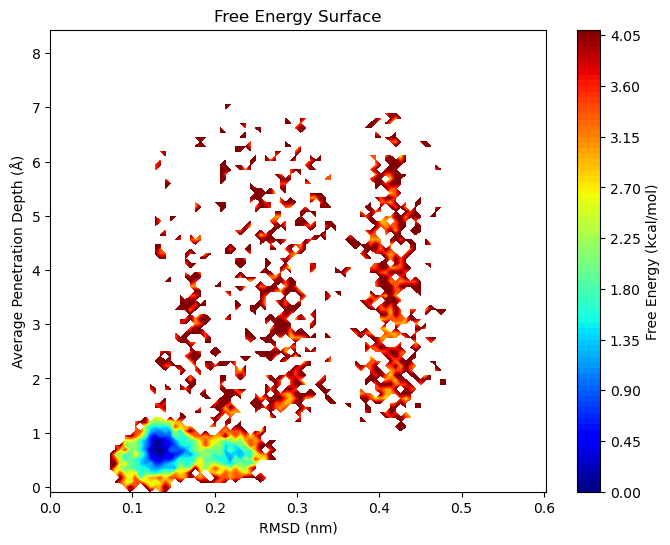

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'all_rmsd_values' and 'average_pen' are the 1D arrays of your data
# Create a 2D histogram with the desired number of bins
# You can adjust the bins and density=True to your needs
h, xedges, yedges = np.histogram2d(all_rmsd_values, average_pen, bins=100, density=True)

# Calculate the free energy
free_energy = -np.log(h)
free_energy -= free_energy.min()  # Set the minimum to 0
free_energy[np.isinf(free_energy)] = free_energy.max()  # Set infinities to the max value

# Create the plot using the 'jet' colormap, which is similar to your uploaded plot's colormap
# The limits for the colorbar will be set based on the min and max of the free_energy array
plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(xedges, yedges)
plt.contourf(X[:-1, :-1], Y[:-1, :-1], free_energy.T, 100, cmap='jet')
plt.colorbar(label='Free Energy (kcal/mol)')

plt.xlabel('RMSD (nm)')
plt.ylabel('Average Penetration Depth (Å)')
plt.title('Free Energy Surface')

plt.show()


In [35]:
import mdtraj as md
import pyemma
from pyemma.coordinates import source
from pyemma.util.contexts import settings
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import pyemma
from pyemma.coordinates import source
from pyemma.util.contexts import settings

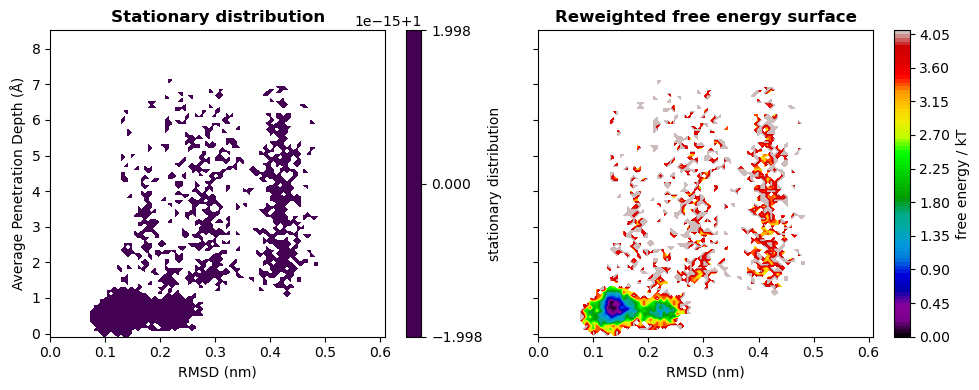

In [20]:
import matplotlib.pyplot as plt
import pyemma.plots as pyemma_plots

# Assuming 'all_rmsd_values' is a 1D NumPy array with your RMSD values
# Assuming 'average_pen' is a 1D NumPy array with your average penetration depths
# We need to combine them just like TICA components:
data_to_plot = np.vstack((all_rmsd_values, average_pen)).T

# Generate a pseudo stationary distribution if you don't have one
# This could be a uniform distribution or based on some criterion you have
# Here, we use ones, which implies equal probability for all data points
pseudo_stationary_distribution = np.ones(data_to_plot.shape[0])

# Generate pseudo weights for the plot_free_energy function
# This could be uniform weights or based on some criterion you have
pseudo_weights = np.ones(data_to_plot.shape[0])

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Replace `msm.pi[dtrajs_concatenated]` with your pseudo_stationary_distribution
pyemma_plots.plot_contour(
    data_to_plot[:, 0],
    data_to_plot[:, 1],
    pseudo_stationary_distribution,
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')

# Replace `np.concatenate(msm.trajectory_weights())` with your pseudo_weights
pyemma_plots.plot_free_energy(
    data_to_plot[:, 0],
    data_to_plot[:, 1],
    weights=pseudo_weights,
    ax=axes[1],
    legacy=False)

# Set labels and titles
for ax in axes.flat:
    ax.set_xlabel('RMSD (nm)')
axes[0].set_ylabel('Average Penetration Depth (Å)')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')

fig.tight_layout()
plt.show()


# Now lets do tilt angle with COM

In [22]:
import MDAnalysis as mda

In [22]:
def calculate_tilt_angle(traj, start_residue, end_residue):
    
    tilt_angles = []
    for frame in traj:
        start_atom = u.select_atoms(f"resid {start_residue} and name CA").center_of_mass()
        end_atom = u.select_atoms(f"resid {end_residue} and name CA").center_of_mass()

        helix_vector = end_atom - start_atom
        helix_vector /= np.linalg.norm(helix_vector)
        dot_product = np.dot(helix_vector, [0, 0, 1])
        angle_with_z = np.arccos(dot_product) * 180.0 / np.pi
        angle_with_xy = 90 - angle_with_z

        center_atom_z = u.select_atoms(f"resid {start_residue} and name CA").center_of_mass()[2]
        box_center_z = u.dimensions[2] / 2.0
        if center_atom_z < box_center_z:
            angle_with_xy = -angle_with_xy
        tilt_angles.append(angle_with_xy)
    

    return tilt_angles



In [43]:
helix_ranges = [(20, 36)] 
helix = calculate_tilt_angle(20,36)

In [23]:
tilt_angle_values = []

In [ ]:
for traj_file in trajectories:
    traj = md.load(traj_file, top=topology)
    tilt_angles = calculate_tilt_angle(traj, 20,36)
    tilt_angle_values.extend(tilt_angles)

# Now you have all the tilt angles calculated
# You can save these to a numpy array file


In [3]:
np.shape(tilt_angles_values)

NameError: name 'tilt_angles_values' is not defined